In [9]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error
from sklearn.manifold import TSNE, Isomap
from sklearn.preprocessing import StandardScaler



all_df = pd.read_csv("gene_predicted_rest_median_imputed.csv", index_col=False)
all_df.drop('ID', axis=1, inplace=True)
all_df.head()
# classification target
clf_y = all_df['pCR (outcome)']
X_clf = all_df[clf_y != 999]
X_clf = X_clf.iloc[:, 2:]
clf_y = clf_y[clf_y != 999]
# regression target
rgr_y = all_df['RelapseFreeSurvival (outcome)']
X_rgr = all_df[rgr_y != 999]
X_rgr = X_rgr.iloc[:, 2:]
rgr_y = rgr_y[rgr_y != 999]

In [18]:
X_rgr.shape
rgr_y.shape

(264,)

### OUTLIER OPTION A: Ralph's Implementation

In [11]:
outlier_indices = set()
for column in X_rgr.columns:
    Q1 = X_rgr[column].quantile(0.25)
    Q3 = X_rgr[column].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 5 * IQR
    upper_bound = Q3 + 5 * IQR

    outliers = X_rgr[(X_rgr[column] < lower_bound) | (X_rgr[column] > upper_bound)].index
    outlier_indices.update(outliers)

    outliers_sum = ((X_rgr[column] < lower_bound) | (X_rgr[column] > upper_bound)).sum()
    print(f'{column}: {outliers_sum} outliers')

outlier_indices = list(outlier_indices)

X_rgr = X_rgr.drop(index=outlier_indices)
rgr_y = rgr_y.drop(index=outlier_indices)
clf_y = clf_y.drop(index=outlier_indices)

Age: 0 outliers
ER: 0 outliers
PgR: 0 outliers
HER2: 0 outliers
TrippleNegative: 0 outliers
ChemoGrade: 0 outliers
Proliferation: 0 outliers
HistologyType: 58 outliers
LNStatus: 0 outliers
TumourStage: 0 outliers
Gene: 0 outliers
original_shape_Elongation: 0 outliers
original_shape_Flatness: 0 outliers
original_shape_LeastAxisLength: 1 outliers
original_shape_MajorAxisLength: 2 outliers
original_shape_Maximum2DDiameterColumn: 0 outliers
original_shape_Maximum2DDiameterRow: 3 outliers
original_shape_Maximum2DDiameterSlice: 1 outliers
original_shape_Maximum3DDiameter: 1 outliers
original_shape_MeshVolume: 7 outliers
original_shape_MinorAxisLength: 1 outliers
original_shape_Sphericity: 0 outliers
original_shape_SurfaceArea: 5 outliers
original_shape_SurfaceVolumeRatio: 0 outliers
original_shape_VoxelVolume: 7 outliers
original_firstorder_10Percentile: 0 outliers
original_firstorder_90Percentile: 0 outliers
original_firstorder_Energy: 13 outliers
original_firstorder_Entropy: 0 outliers
ori

## OUTLIER OPTION B: Tomas' Implementation

In [12]:
def percentile_based_outlier(data, threshold=95):
    diff = (100 - threshold) / 2.0
    minval, maxval = np.percentile(data, [diff, 100 - diff])
    return (data < minval) | (data > maxval)

def mad_based_outlier(points, threshold=3.5):
    points = np.array(points)
    if len(points.shape) == 1:
        points = points[:, None]
    median_y = np.median(points)
    median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in points])
    # Small constant added to avoid division by zero
    modified_z_scores = [0.6745 * (y - median_y) / (median_absolute_deviation_y + 1e-6) for y in points]

    return np.abs(modified_z_scores) > threshold

def std_div(data, threshold=3):
    std = data.std()
    mean = data.mean()
    isOutlier = []
    for val in data:
        if abs(val - mean)/std > threshold:
            isOutlier.append(True)
        else:
            isOutlier.append(False)
    return isOutlier

def outlierVote(data):
    x = percentile_based_outlier(data)
    y = mad_based_outlier(data)
    z = std_div(data)
    temp = list(zip(x, y, z))
    final = []
    for i in range(len(temp)):
        if temp[i].count(False) >= 2:
            final.append(False)
        else:
            final.append(True)
    return final

def plotOutliers(x):
    fig, axes = plt.subplots(nrows=4)
    for ax, func in zip(axes, [percentile_based_outlier, mad_based_outlier, std_div, outlierVote]):
        sns.distplot(x, ax=ax, rug=True, hist=False)
        outliers = func(x)
        ax.plot(outliers, np.zeros_like(outliers), 'ro', clip_on=False)

    kwargs = dict(y=0.95, x=0.05, ha='left', va='top', size=20)
    axes[0].set_title('Percentile-based Outliers', **kwargs)
    axes[1].set_title('MAD-based Outliers', **kwargs)
    axes[2].set_title('STD-based Outliers', **kwargs)
    axes[3].set_title('Majority vote', **kwargs)
    fig.suptitle('Comparing Outlier Tests with n={}'.format(len(x)), size=20)
    fig = plt.gcf()
    fig.set_size_inches(20, 15)

def removeOutliers(data):
    # Remove outliers from the dataframe
    for column in data.columns:
        outliers = outlierVote(all_df[column])
        # Calculate Non-Outlier Maximum using the outliers list
        non_outlier_max = all_df.loc[~np.array(outliers), column].max()
        # Replace outliers with the maximum non-outlier value
        data.loc[outliers, column] = non_outlier_max

removeOutliers(all_df)
# Verify the changes
all_df.head()

# Assign features to X
X = all_df.drop(['pCR (outcome)', 'RelapseFreeSurvival (outcome)'], axis=1)

In [13]:
X_rgr.shape

(264, 118)

In [ ]:
# Normalise X_rgr using sklearn's StandardScaler
scaler = StandardScaler()
X_rgr = scaler.fit_transform(X_rgr)

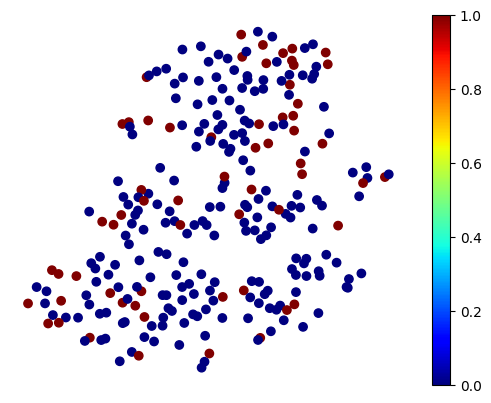

In [15]:
# Create manifold of MRI scan data (columns 11 onwards)

tsne = TSNE(n_components=2, random_state=42)
# isomap = Isomap(n_components=)
X_tsne_mri = tsne.fit_transform(X_rgr[:,11:])

# plot manifold
plt.scatter(X_tsne_mri[:, -2], X_tsne_mri[:, -1], c=clf_y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

# combine columns 0-10 with the manifold
X_tsne_mri = np.c_[X_rgr[:,0:11], X_tsne_mri]

In [16]:
import umap.umap_ as umap

# Create manifold of MRI scan data (columns 11 onwards)

# Create UMAP manifold of MRI scan data (columns 11 onwards)
umap_model = umap.UMAP(n_components=2, random_state=42)
X_umap_mri = umap_model.fit_transform(X_rgr[:, 11:])

# plot manifold
plt.scatter(X_umap_mri[:, 0], X_umap_mri[:, 1], c=rgr_y, cmap="jet")
plt.axis('off')
plt.colorbar()
plt.show()

# combine columns 0-10 with the manifold
X_umap_mri = np.c_[X_rgr[:, 0:11], X_umap_mri]

ModuleNotFoundError: No module named 'umap.umap_'

## Nested K-Fold Validation: Number of Dimensions
#### Not much better

In [ ]:
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1)
svr_outer = SVR(C=3, gamma=0.1, kernel='rbf')
svr_inner = SVR(C=3, gamma=0.1, kernel='rbf')
n_neighbours = 5
n_dimensions_range = 10 # Set hyperparameter range of values
kf_inner = KFold(n_splits=n_dimensions_range, shuffle=True, random_state=1) # Create kfold for inner loop

best_n_dimensions_list = []   # Best degrees resulting from inner fold
best_val_mae_list = []  # For inner fold
test_mae_list = [] # For outer fold

for train_index, test_index in kf.split(X_umap_mri):
    X_train, X_test = X_umap_mri[train_index],X_umap_mri[test_index]
    y_train, y_test = rgr_y.iloc[train_index], rgr_y.iloc[test_index]

    best_n_dimensions = 1
    best_val_mae = np.inf

    degree = 1
    for train_index_inner, val_index in kf_inner.split(X_train):
        X_train_inner, X_val = X_train[train_index_inner],  X_train[val_index]
        y_train_inner, y_val = y_train.iloc[train_index_inner],  y_train.iloc[val_index]

        # train model with x_train_inner and y_train_inner with n dimensions
        umap_inner = umap.UMAP(n_components=degree, random_state=42, n_neighbors = n_neighbours)

        # Create the pure and interaction terms of degree n
        X_umap_train_inner = umap_inner.fit_transform(X_train_inner[:,11:])
        X_umap_train_inner = np.c_[X_train_inner[:,0:11], X_umap_train_inner]
        X_umap_val = umap_inner.fit_transform(X_val[:,11:])
        X_umap_val = np.c_[X_val[:,0:11], X_umap_val]

        svr_inner.fit(X_umap_train_inner, y_train_inner)

        # validate model on validation data and get MAE
        y_pred_inner = svr_inner.predict(X_umap_val)
        mae = mean_absolute_error(y_val, y_pred_inner)
        print(f"Degree {degree} Validation MAE: {mae:.4}", end=" ---- ")

        # if MAE is best so far, save degree and MAE
        if mae < best_val_mae:
            best_val_mae = mae
            best_degree = degree

        degree += 1
    
    best_n_dimensions_list.append(best_degree)
    best_val_mae_list.append(best_val_mae)

    umap_outer = umap.UMAP(n_components=best_degree, random_state=42, n_neighbors = n_neighbours)
    X_train_umap = umap_outer.fit_transform(X_train[:,11:])
    X_train_umap = np.c_[X_train[:,0:11], X_train_umap]
    X_test_umap = umap_outer.fit_transform(X_test[:,11:])
    X_test_umap = np.c_[X_test[:,0:11], X_test_umap]
    
    svr_outer.fit(X_train_umap, y_train)

    y_pred_test = svr_outer.predict(X_test_umap)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mae_list.append(test_mae)

print("\nSummary of outer folds:")
for i in range(num_splits):
    print(f"Fold {i+1}: Best Degree of {best_n_dimensions_list[i]}, Validation MAE = {best_val_mae_list[i]:.4f}, Test MAE = {test_mae_list[i]:.4f}")

print(f"\nAverage Test MAE: {np.mean(test_mae_list):.4f}")


c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 1 Validation MAE: 24.71 ---- Degree 2 Validation MAE: 20.61 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 3 Validation MAE: 21.62 ---- Degree 4 Validation MAE: 23.63 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 5 Validation MAE: 20.44 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 6 Validation MAE: 23.4 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 7 Validation MAE: 24.59 ---- Degree 8 Validation MAE: 21.39 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 9 Validation MAE: 25.13 ---- Degree 10 Validation MAE: 18.34 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 1 Validation MAE: 24.06 ---- Degree 2 Validation MAE: 18.66 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 3 Validation MAE: 22.51 ---- Degree 4 Validation MAE: 19.49 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 5 Validation MAE: 20.27 ---- Degree 6 Validation MAE: 20.92 ---- Degree 7 Validation MAE: 19.8 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 8 Validation MAE: 22.69 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 9 Validation MAE: 27.65 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 10 Validation MAE: 19.93 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 1 Validation MAE: 27.47 ---- Degree 2 Validation MAE: 17.85 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 3 Validation MAE: 21.2 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 4 Validation MAE: 22.63 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 5 Validation MAE: 21.83 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 6 Validation MAE: 18.21 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 7 Validation MAE: 27.33 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 8 Validation MAE: 22.65 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 9 Validation MAE: 24.46 ---- Degree 10 Validation MAE: 19.34 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 1 Validation MAE: 23.21 ---- Degree 2 Validation MAE: 25.68 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 3 Validation MAE: 21.57 ---- Degree 4 Validation MAE: 21.32 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 5 Validation MAE: 17.23 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 6 Validation MAE: 21.33 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 7 Validation MAE: 20.29 ---- Degree 8 Validation MAE: 22.14 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 9 Validation MAE: 23.07 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 10 Validation MAE: 18.84 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 1 Validation MAE: 27.71 ---- Degree 2 Validation MAE: 24.86 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 3 Validation MAE: 17.71 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 4 Validation MAE: 22.0 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 5 Validation MAE: 17.46 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 6 Validation MAE: 23.76 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 7 Validation MAE: 18.14 ---- Degree 8 Validation MAE: 24.31 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 9 Validation MAE: 24.23 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Degree 10 Validation MAE: 20.49 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Summary of outer folds:
Fold 1: Best Degree of 10, Validation MAE = 18.3423, Test MAE = 19.8050
Fold 2: Best Degree of 2, Validation MAE = 18.6625, Test MAE = 22.8543
Fold 3: Best Degree of 2, Validation MAE = 17.8548, Test MAE = 20.0847
Fold 4: Best Degree of 5, Validation MAE = 17.2349, Test MAE = 23.7966
Fold 5: Best Degree of 5, Validation MAE = 17.4642, Test MAE = 21.9420

Average Test MAE: 21.6965


## Nested K-Fold Validation: Number of Neighbours

In [ ]:
num_splits = 5
kf = KFold(n_splits=num_splits, shuffle=True, random_state=1)
svr_outer = SVR(C=10, gamma=0.01, kernel='rbf')
svr_inner = SVR(C=10, gamma=0.01, kernel='rbf')

n_neighbours_range= np.linspace(5, 30, 6) # Set hyperparameter range of values
kf_inner = KFold(n_splits=len(n_neighbours_range), shuffle=True, random_state=1) # Create kfold for inner loop

best_n_neighbours_list = []   # Best n_neighbours resulting from inner fold
best_val_mae_list = []  # For inner fold
test_mae_list = [] # For outer fold

dimension = 2
for train_index, test_index in kf.split(X_umap_mri):
    X_train, X_test = X_umap_mri[train_index],X_umap_mri[test_index]
    y_train, y_test = rgr_y.iloc[train_index], rgr_y.iloc[test_index]

    best_n_neighbours = 1
    best_val_mae = np.inf

    index = 0
    for train_index_inner, val_index in kf_inner.split(X_train):
        n_neighbours = n_neighbours_range[index]
        X_train_inner, X_val = X_train[train_index_inner],  X_train[val_index]
        y_train_inner, y_val = y_train.iloc[train_index_inner],  y_train.iloc[val_index]

        # train model with x_train_inner and y_train_inner with n neighbours
        umap_inner = umap.UMAP(n_components=dimension, random_state=42, n_neighbors=int(n_neighbours))

        # Create the pure and interaction terms of n_neighbours n
        X_umap_train_inner = umap_inner.fit_transform(X_train_inner[:,11:])
        X_umap_train_inner = np.c_[X_train_inner[:,0:11], X_umap_train_inner]
        X_umap_val = umap_inner.fit_transform(X_val[:,11:])
        X_umap_val = np.c_[X_val[:,0:11], X_umap_val]

        svr_inner.fit(X_umap_train_inner, y_train_inner)

        # validate model on validation data and get MAE
        y_pred_inner = svr_inner.predict(X_umap_val)
        mae = mean_absolute_error(y_val, y_pred_inner)
        print(f"n_neighbours {n_neighbours} Validation MAE: {mae:.4}", end=" ---- ")

        # if MAE is best so far, save n_neighbours and MAE
        if mae < best_val_mae:
            best_val_mae = mae
            best_n_neighbours = n_neighbours

        n_neighbours += 1
    
    best_n_neighbours_list.append(best_n_neighbours)
    best_val_mae_list.append(best_val_mae)

    umap_outer = umap.UMAP(n_components=dimension, random_state=42, n_neighbors=int(best_n_neighbours))
    X_train_umap = umap_outer.fit_transform(X_train[:,11:])
    X_train_umap = np.c_[X_train[:,0:11], X_train_umap]
    X_test_umap = umap_outer.fit_transform(X_test[:,11:])
    X_test_umap = np.c_[X_test[:,0:11], X_test_umap]
    
    svr_outer.fit(X_train_umap, y_train)

    y_pred_test = svr_outer.predict(X_test_umap)
    test_mae = mean_absolute_error(y_test, y_pred_test)
    test_mae_list.append(test_mae)

print("\nSummary of outer folds:")
for i in range(num_splits):
    print(f"Fold {i+1}: Best n_neighbours of {best_n_neighbours_list[i]}, Validation MAE = {best_val_mae_list[i]:.4f}, Test MAE = {test_mae_list[i]:.4f}")

print(f"\nAverage Test MAE: {np.mean(test_mae_list):.4f}")


c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 23.07 ---- n_neighbours 5.0 Validation MAE: 20.79 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 22.56 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 25.78 ---- n_neighbours 5.0 Validation MAE: 22.35 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 21.68 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 24.02 ---- n_neighbours 5.0 Validation MAE: 19.86 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 22.42 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 20.98 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 20.95 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 25.26 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 24.96 ---- n_neighbours 5.0 Validation MAE: 19.9 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 24.27 ---- n_neighbours 5.0 Validation MAE: 21.12 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 24.31 ---- n_neighbours 5.0 Validation MAE: 19.54 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 23.76 ---- n_neighbours 5.0 Validation MAE: 21.79 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 18.61 ---- n_neighbours 5.0 Validation MAE: 20.81 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 21.47 ---- n_neighbours 5.0 Validation MAE: 20.04 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 29.96 ---- n_neighbours 5.0 Validation MAE: 20.64 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 19.62 ---- n_neighbours 5.0 Validation MAE: 20.56 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


n_neighbours 5.0 Validation MAE: 22.71 ---- n_neighbours 5.0 Validation MAE: 21.58 ---- 

c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
c:\Users\ralph\Desktop\Virtual Environments\ML\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(



Summary of outer folds:
Fold 1: Best n_neighbours of 5.0, Validation MAE = 20.7907, Test MAE = 20.1049
Fold 2: Best n_neighbours of 5.0, Validation MAE = 19.8609, Test MAE = 23.2814
Fold 3: Best n_neighbours of 5.0, Validation MAE = 19.5405, Test MAE = 19.5072
Fold 4: Best n_neighbours of 5.0, Validation MAE = 18.6133, Test MAE = 22.9966
Fold 5: Best n_neighbours of 5.0, Validation MAE = 19.6188, Test MAE = 22.4111

Average Test MAE: 21.6602
